In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score,roc_curve,classification_report
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from mlxtend.classifier import StackingCVClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

In [5]:
binary = pd.CategoricalDtype(categories=[0, 1])
data = pd.read_csv(
    'processed.cleveland.data',
    header=None,
    na_values='?',
    names='age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpeak, slope, ca, thal, target'.split(', '),
    dtype={
        'sex':binary,
        'cp':pd.CategoricalDtype(categories=range(1,5)),
        'fbs':binary,
        'restecg':pd.CategoricalDtype(categories=range(3)),
        'exang':binary,
        'slope':pd.CategoricalDtype(categories=range(1,4)),
        'ca':pd.CategoricalDtype(categories=range(4)),
        'thal':pd.CategoricalDtype(categories=[3,6,7]),
        'target':pd.CategoricalDtype(categories=range(2), ordered=True),
    }
)

In [6]:
data.target.value_counts()

0    164
1     55
Name: target, dtype: int64

In [7]:
data = data.fillna({'ca':0, 'thal':3, 'target':1})
data.target.value_counts()

0    164
1    139
Name: target, dtype: int64

In [8]:
mas = data.dtypes == 'category'
data.columns[mas][:-1]

Index(['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal'], dtype='object')

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       303 non-null    float64 
 1   sex       303 non-null    category
 2   cp        303 non-null    category
 3   trestbps  303 non-null    float64 
 4   chol      303 non-null    float64 
 5   fbs       303 non-null    category
 6   restecg   303 non-null    category
 7   thalach   303 non-null    float64 
 8   exang     303 non-null    category
 9   oldpeak   303 non-null    float64 
 10  slope     303 non-null    category
 11  ca        303 non-null    category
 12  thal      303 non-null    category
 13  target    303 non-null    category
dtypes: category(9), float64(5)
memory usage: 15.7 KB


In [10]:
data.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [11]:
data.describe()

,age,trestbps,chol,thalach,oldpeak
count,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.438944,131.689769,246.693069,149.607261,1.039604
std,9.038662,17.599748,51.776918,22.875003,1.161075
min,29.000000,94.000000,126.000000,71.000000,0.000000
25%,48.000000,120.000000,211.000000,133.500000,0.000000
50%,56.000000,130.000000,241.000000,153.000000,0.800000
75%,61.000000,140.000000,275.000000,166.000000,1.600000
max,77.000000,200.000000,564.000000,202.000000,6.200000


Text(0.5, 0.98, 'Pairplot: Numerical Features ')

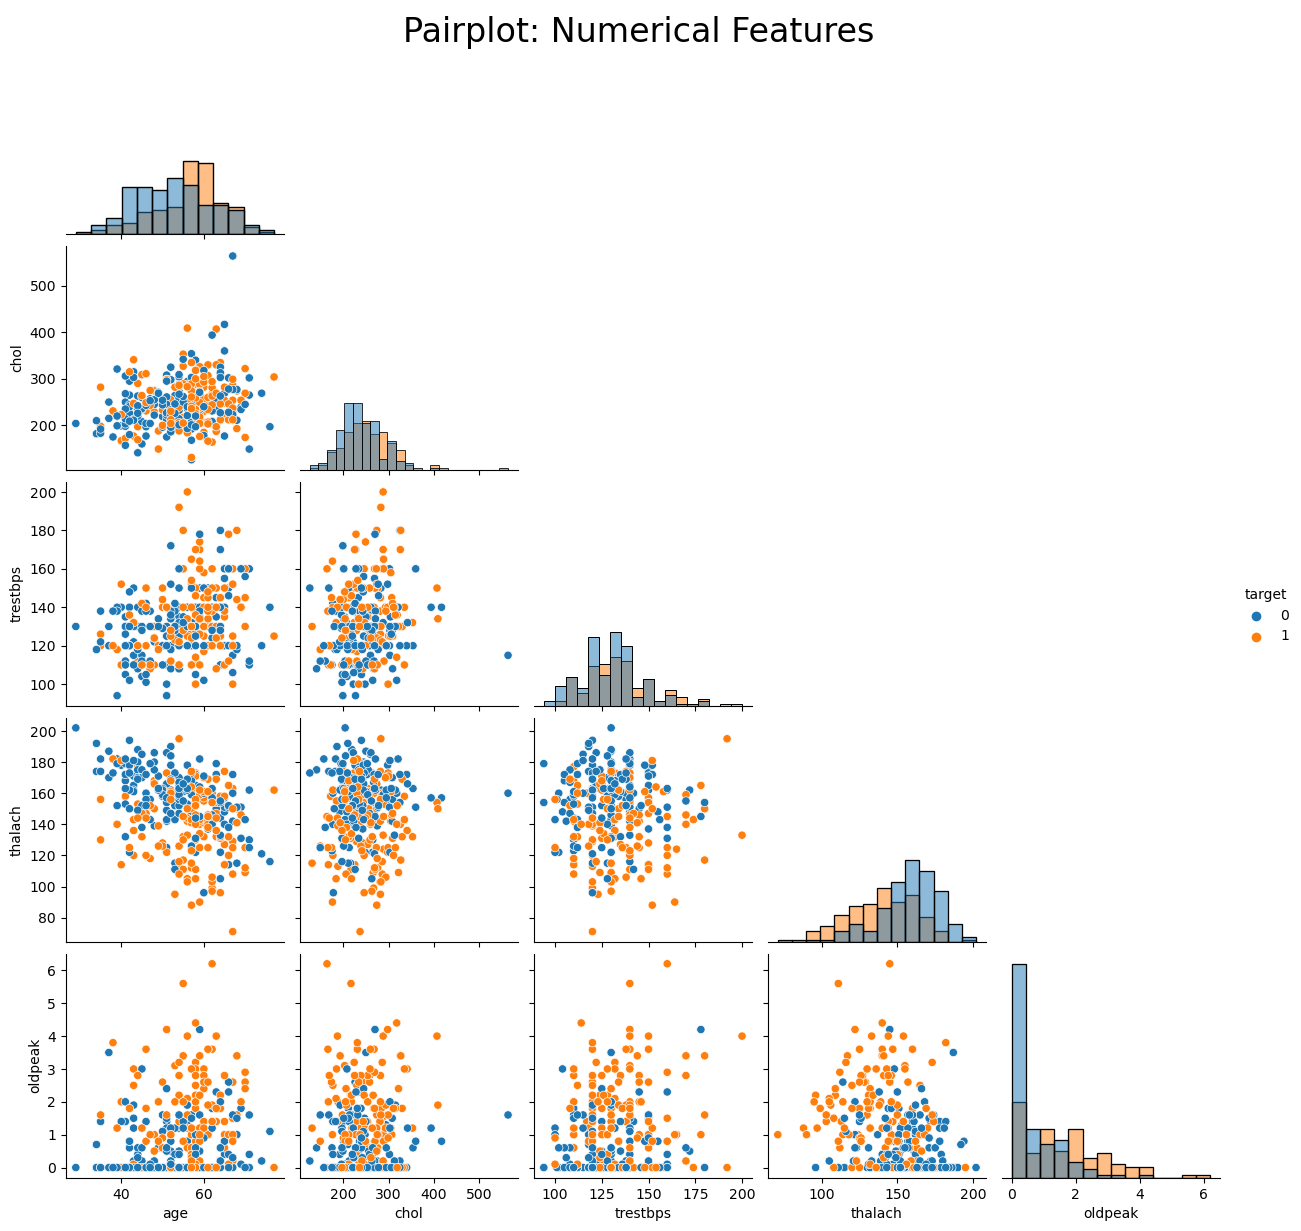

In [14]:
_ = ['age', 'chol', 'trestbps', 'thalach', 'oldpeak', 'target']
data_ = data[_]
g = sns.pairplot(data_, hue="target", corner=True, diag_kind='hist');
plt.suptitle('Pairplot: Numerical Features ' ,fontsize = 24)

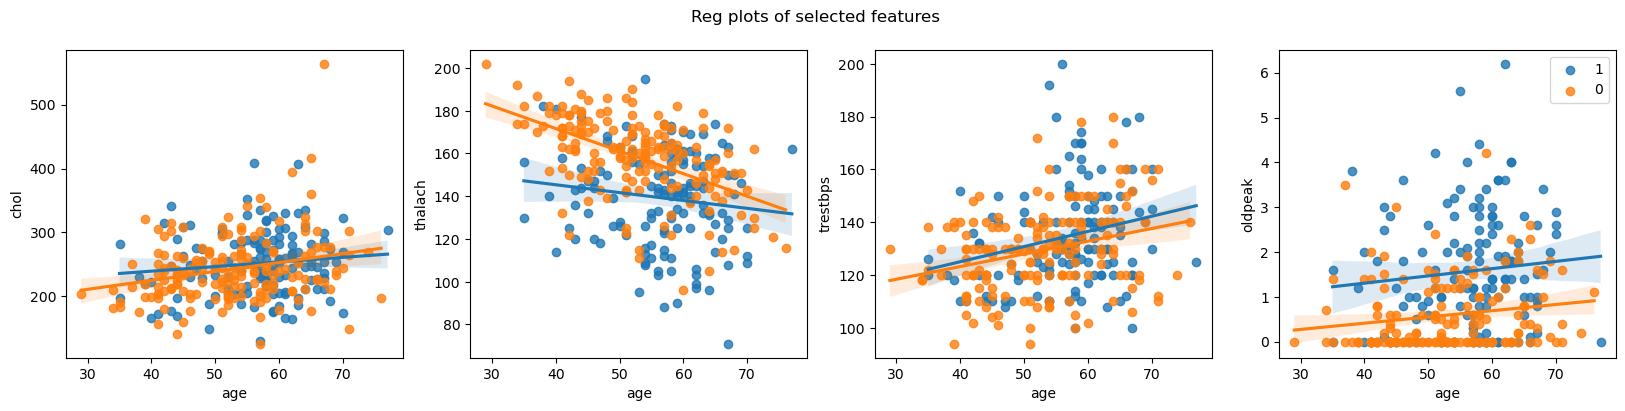

In [15]:
fig, ax = plt.subplots(1,4, figsize=(20, 4))
sns.regplot(data=data[data['target'] ==1], x='age', y='chol', ax = ax[0], label='1')
sns.regplot(data=data[data['target'] ==0], x='age', y='chol', ax = ax[0],  label='0')
sns.regplot(data=data[data['target'] ==1], x='age', y='thalach', ax = ax[1], label='1')
sns.regplot(data=data[data['target'] ==0], x='age', y='thalach', ax = ax[1],  label='0')
sns.regplot(data=data[data['target'] ==1], x='age', y='trestbps', ax = ax[2],  label='1')
sns.regplot(data=data[data['target'] ==0], x='age', y='trestbps', ax = ax[2],  label='0')
sns.regplot(data=data[data['target'] ==1], x='age', y='oldpeak', ax = ax[3],  label='1')
sns.regplot(data=data[data['target'] ==0], x='age', y='oldpeak', ax = ax[3],  label='0')
plt.suptitle('Reg plots of selected features')
plt.legend();

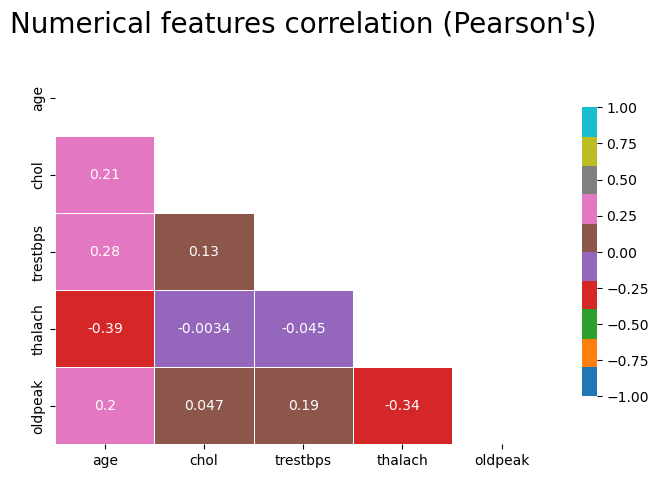

In [16]:
num_feats = ['age', 'chol', 'trestbps', 'thalach', 'oldpeak']
df_ = data[num_feats]
corr = df_.corr( numeric_only = True, method='pearson')
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(8, 5), facecolor=None)
cmap = sns.color_palette( as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1.0, vmin=-1.0, center=0, annot=True,
            square=False, linewidths=.5, cbar_kws={"shrink": 0.75})
ax.set_title("Numerical features correlation (Pearson's)", fontsize=20, y= 1.05);

In [17]:
data = pd.get_dummies(data, columns=data.columns[mas][:-1], drop_first=False)

In [18]:
y = data["target"]
X = data.drop('target',axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 0)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train.shape, X_test.shape

((242, 28), (61, 28))

In [19]:
m1 = 'Logistic Regression'
lr = LogisticRegression()
model = lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)
lr_conf_matrix = confusion_matrix(y_test, lr_predict)
lr_acc_score = accuracy_score(y_test, lr_predict)
print("confussion matrix")
print(lr_conf_matrix)
print("\n")
print("Accuracy of Logistic Regression:",lr_acc_score*100,'\n')
print(classification_report(y_test,lr_predict))

confussion matrix
[[31  4]
 [ 6 20]]


Accuracy of Logistic Regression: 83.60655737704919 

              precision    recall  f1-score   support

           0       0.84      0.89      0.86        35
           1       0.83      0.77      0.80        26

    accuracy                           0.84        61
   macro avg       0.84      0.83      0.83        61
weighted avg       0.84      0.84      0.84        61



In [20]:
m2 = 'Naive Bayes'
nb = GaussianNB()
nb.fit(X_train,y_train)
nbpred = nb.predict(X_test)
nb_conf_matrix = confusion_matrix(y_test, nbpred)
nb_acc_score = accuracy_score(y_test, nbpred)
print("confussion matrix")
print(nb_conf_matrix)
print("\n")
print("Accuracy of Naive Bayes model:",nb_acc_score*100,'\n')
print(classification_report(y_test,nbpred))

confussion matrix
[[32  3]
 [ 8 18]]


Accuracy of Naive Bayes model: 81.9672131147541 

              precision    recall  f1-score   support

           0       0.80      0.91      0.85        35
           1       0.86      0.69      0.77        26

    accuracy                           0.82        61
   macro avg       0.83      0.80      0.81        61
weighted avg       0.82      0.82      0.82        61



In [21]:
m3 = 'Random Forest Classfier'
rf = RandomForestClassifier(n_estimators=20, random_state=2,max_depth=5)
rf.fit(X_train,y_train)
rf_predicted = rf.predict(X_test)
rf_conf_matrix = confusion_matrix(y_test, rf_predicted)
rf_acc_score = accuracy_score(y_test, rf_predicted)
print("confussion matrix")
print(rf_conf_matrix)
print("\n")
print("Accuracy of Random Forest:",rf_acc_score*100,'\n')
print(classification_report(y_test,rf_predicted))

confussion matrix
[[29  6]
 [ 9 17]]


Accuracy of Random Forest: 75.40983606557377 

              precision    recall  f1-score   support

           0       0.76      0.83      0.79        35
           1       0.74      0.65      0.69        26

    accuracy                           0.75        61
   macro avg       0.75      0.74      0.74        61
weighted avg       0.75      0.75      0.75        61



In [22]:
m4 = 'Extreme Gradient Boost'
xgb = XGBClassifier(learning_rate=0.01, n_estimators=25, max_depth=15,gamma=0.6, subsample=0.52,colsample_bytree=0.6,seed=27, 
                    reg_lambda=2, booster='dart', colsample_bylevel=0.6, colsample_bynode=0.5)
xgb.fit(X_train, y_train)
xgb_predicted = xgb.predict(X_test)
xgb_conf_matrix = confusion_matrix(y_test, xgb_predicted)
xgb_acc_score = accuracy_score(y_test, xgb_predicted)
print("confussion matrix")
print(xgb_conf_matrix)
print("\n")
print("Accuracy of Extreme Gradient Boost:",xgb_acc_score*100,'\n')
print(classification_report(y_test,xgb_predicted))

confussion matrix
[[30  5]
 [ 9 17]]


Accuracy of Extreme Gradient Boost: 77.04918032786885 

              precision    recall  f1-score   support

           0       0.77      0.86      0.81        35
           1       0.77      0.65      0.71        26

    accuracy                           0.77        61
   macro avg       0.77      0.76      0.76        61
weighted avg       0.77      0.77      0.77        61



In [23]:
m5 = 'K-NeighborsClassifier'
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)
knn_predicted = knn.predict(X_test)
knn_conf_matrix = confusion_matrix(y_test, knn_predicted)
knn_acc_score = accuracy_score(y_test, knn_predicted)
print("confussion matrix")
print(knn_conf_matrix)
print("\n")
print("Accuracy of K-NeighborsClassifier:",knn_acc_score*100,'\n')
print(classification_report(y_test,knn_predicted))

confussion matrix
[[29  6]
 [ 9 17]]


Accuracy of K-NeighborsClassifier: 75.40983606557377 

              precision    recall  f1-score   support

           0       0.76      0.83      0.79        35
           1       0.74      0.65      0.69        26

    accuracy                           0.75        61
   macro avg       0.75      0.74      0.74        61
weighted avg       0.75      0.75      0.75        61



In [24]:
m6 = 'DecisionTreeClassifier'
dt = DecisionTreeClassifier(criterion = 'entropy',random_state=0,max_depth = 6)
dt.fit(X_train, y_train)
dt_predicted = dt.predict(X_test)
dt_conf_matrix = confusion_matrix(y_test, dt_predicted)
dt_acc_score = accuracy_score(y_test, dt_predicted)
print("confussion matrix")
print(dt_conf_matrix)
print("\n")
print("Accuracy of DecisionTreeClassifier:",dt_acc_score*100,'\n')
print(classification_report(y_test,dt_predicted))

confussion matrix
[[27  8]
 [ 9 17]]


Accuracy of DecisionTreeClassifier: 72.1311475409836 

              precision    recall  f1-score   support

           0       0.75      0.77      0.76        35
           1       0.68      0.65      0.67        26

    accuracy                           0.72        61
   macro avg       0.72      0.71      0.71        61
weighted avg       0.72      0.72      0.72        61



In [25]:
m7 = 'Support Vector Classifier'
svc =  SVC(kernel='rbf', C=2)
svc.fit(X_train, y_train)
svc_predicted = svc.predict(X_test)
svc_conf_matrix = confusion_matrix(y_test, svc_predicted)
svc_acc_score = accuracy_score(y_test, svc_predicted)
print("confussion matrix")
print(svc_conf_matrix)
print("\n")
print("Accuracy of Support Vector Classifier:",svc_acc_score*100,'\n')
print(classification_report(y_test,svc_predicted))

confussion matrix
[[31  4]
 [ 7 19]]


Accuracy of Support Vector Classifier: 81.9672131147541 

              precision    recall  f1-score   support

           0       0.82      0.89      0.85        35
           1       0.83      0.73      0.78        26

    accuracy                           0.82        61
   macro avg       0.82      0.81      0.81        61
weighted avg       0.82      0.82      0.82        61



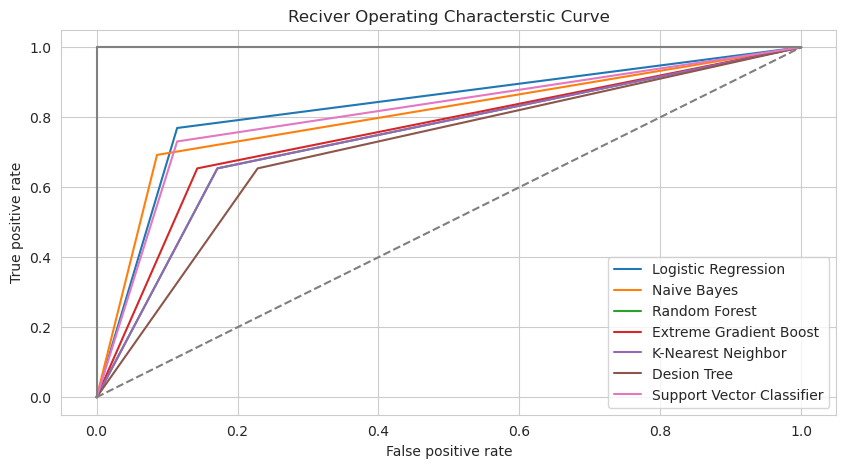

In [26]:
lr_false_positive_rate,lr_true_positive_rate,lr_threshold = roc_curve(y_test,lr_predict)
nb_false_positive_rate,nb_true_positive_rate,nb_threshold = roc_curve(y_test,nbpred)
rf_false_positive_rate,rf_true_positive_rate,rf_threshold = roc_curve(y_test,rf_predicted)                                                             
xgb_false_positive_rate,xgb_true_positive_rate,xgb_threshold = roc_curve(y_test,xgb_predicted)
knn_false_positive_rate,knn_true_positive_rate,knn_threshold = roc_curve(y_test,knn_predicted)
dt_false_positive_rate,dt_true_positive_rate,dt_threshold = roc_curve(y_test,dt_predicted)
svc_false_positive_rate,svc_true_positive_rate,svc_threshold = roc_curve(y_test,svc_predicted)


sns.set_style('whitegrid')
plt.figure(figsize=(10,5))
plt.title('Reciver Operating Characterstic Curve')
plt.plot(lr_false_positive_rate,lr_true_positive_rate,label='Logistic Regression')
plt.plot(nb_false_positive_rate,nb_true_positive_rate,label='Naive Bayes')
plt.plot(rf_false_positive_rate,rf_true_positive_rate,label='Random Forest')
plt.plot(xgb_false_positive_rate,xgb_true_positive_rate,label='Extreme Gradient Boost')
plt.plot(knn_false_positive_rate,knn_true_positive_rate,label='K-Nearest Neighbor')
plt.plot(dt_false_positive_rate,dt_true_positive_rate,label='Desion Tree')
plt.plot(svc_false_positive_rate,svc_true_positive_rate,label='Support Vector Classifier')
plt.plot([0,1],ls='--')
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.legend()
plt.show()

In [27]:
model_ev = pd.DataFrame({'Model': ['Logistic Regression','Naive Bayes','Random Forest','Extreme Gradient Boost',
                    'K-Nearest Neighbour','Decision Tree','Support Vector Machine'], 
                         'Accuracy': [lr_acc_score*100,
                    nb_acc_score*100,rf_acc_score*100,xgb_acc_score*100,knn_acc_score*100,dt_acc_score*100,
                                      svc_acc_score*100]})
model_ev

,Model,Accuracy
0,Logistic Regression,83.606557
1,Naive Bayes,81.967213
2,Random Forest,75.409836
3,Extreme Gradient Boost,77.049180
4,K-Nearest Neighbour,75.409836
5,Decision Tree,72.131148
6,Support Vector Machine,81.967213


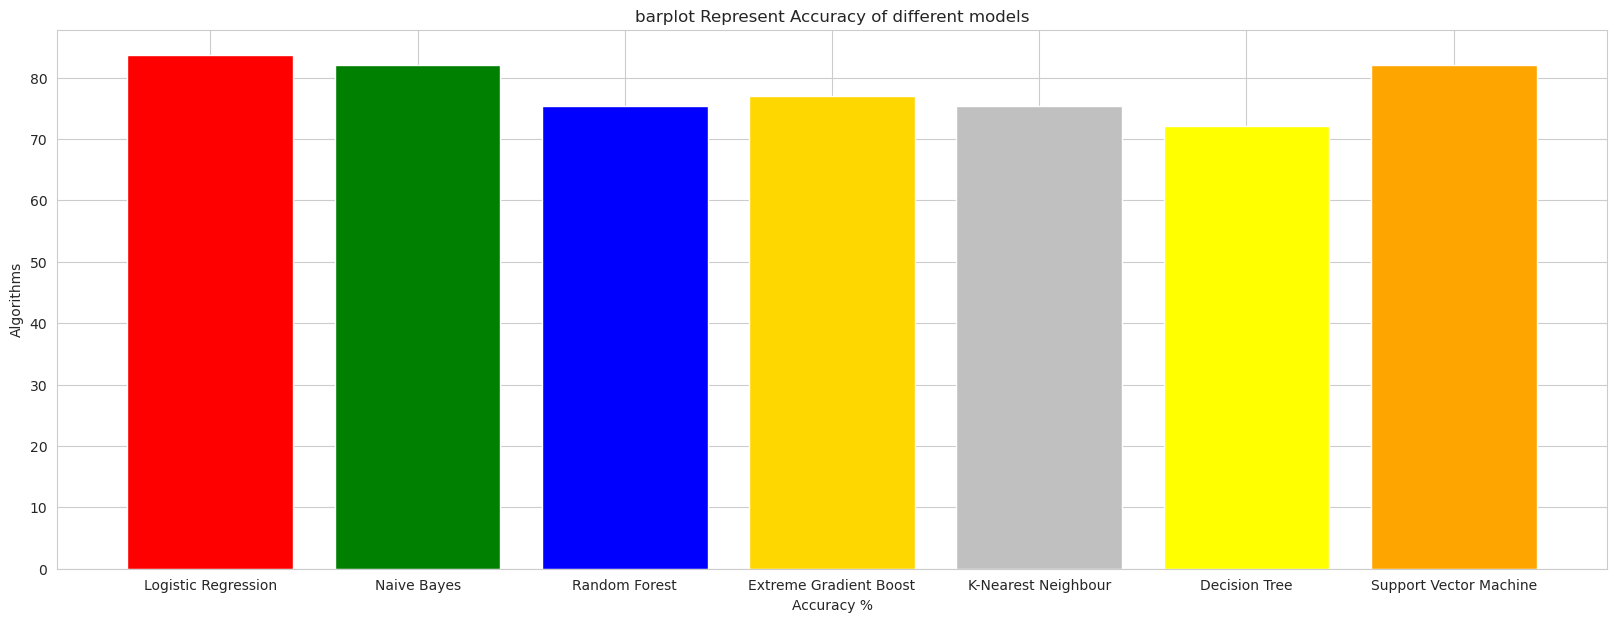

In [28]:
colors = ['red','green','blue','gold','silver','yellow','orange',]
plt.figure(figsize=(20,7))
plt.title("barplot Represent Accuracy of different models")
plt.xlabel("Accuracy %")
plt.ylabel("Algorithms")
plt.bar(model_ev['Model'],model_ev['Accuracy'],color = colors)
plt.show()

In [29]:
scv=StackingCVClassifier(classifiers=[xgb,knn,svc],meta_classifier= svc,random_state=42)
scv.fit(X_train,y_train)
scv_predicted = scv.predict(X_test)
scv_conf_matrix = confusion_matrix(y_test, scv_predicted)
scv_acc_score = accuracy_score(y_test, scv_predicted)
print("confussion matrix")
print(scv_conf_matrix)
print("\n")
print("Accuracy of StackingCVClassifier:",scv_acc_score*100,'\n')
print(classification_report(y_test,scv_predicted))

confussion matrix
[[29  6]
 [ 9 17]]


Accuracy of StackingCVClassifier: 75.40983606557377 

              precision    recall  f1-score   support

           0       0.76      0.83      0.79        35
           1       0.74      0.65      0.69        26

    accuracy                           0.75        61
   macro avg       0.75      0.74      0.74        61
weighted avg       0.75      0.75      0.75        61



In [30]:
lin_clf = LinearSVC(random_state=42)
lin_clf.fit(X_train, y_train)

LinearSVC(random_state=42)

In [31]:
lin_clf = LinearSVC(max_iter=1_000_000, random_state=42)
lin_clf.fit(X_train, y_train)

LinearSVC(max_iter=1000000, random_state=42)

In [32]:
cross_val_score(lin_clf, X_train, y_train).mean()

0.8350340136054422

In [33]:
lin_clf = make_pipeline(StandardScaler(),
                        LinearSVC(random_state=42))
lin_clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC(random_state=42))])

In [34]:
cross_val_score(lin_clf, X_train, y_train).mean()

/home/cmos/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/cmos/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/cmos/.local/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.8350340136054422

In [35]:
svm_clf = make_pipeline(StandardScaler(), SVC(random_state=42))
cross_val_score(svm_clf, X_train, y_train).mean()

0.826530612244898

In [36]:
param_distrib = {
    "svc__gamma": reciprocal(0.001, 0.1),
    "svc__C": uniform(1, 10)
}
rnd_search_cv = RandomizedSearchCV(svm_clf, param_distrib, n_iter=100, cv=5,
                                   random_state=42)
rnd_search_cv.fit(X_train, y_train)
rnd_search_cv.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc',
                 SVC(C=8.712703466859457, gamma=0.001406336677771817,
                     random_state=42))])

In [37]:
rnd_search_cv.best_score_

0.8555272108843537

In [38]:
rnd_search_cv.score(X_test, y_test)

0.819672131147541

In [39]:
scv_conf_matrix = confusion_matrix(y_test, scv_predicted)
scv_conf_matrix

array([[29,  6],
       [ 9, 17]])

In [40]:
scv_acc_score = accuracy_score(y_test, scv_predicted)
scv_acc_score

0.7540983606557377

In [41]:
param_distrib = {
    "svc__gamma": reciprocal(0.00001, 0.001),
    "svc__C": uniform(1, 10)
}
rnd_search_cv = RandomizedSearchCV(svm_clf, param_distrib, n_iter=100, cv=5,
                                   random_state=42)
rnd_search_cv.fit(X_train, y_train)
rnd_search_cv.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc',
                 SVC(C=8.068573438476172, gamma=0.00028708753481954667,
                     random_state=42))])

In [42]:
rnd_search_cv.best_score_

0.8511904761904763

In [43]:
rnd_search_cv.score(X_test, y_test)

0.8032786885245902

In [44]:
param_distrib = {
    "svc__gamma": reciprocal(1, 10),
    "svc__C": uniform(1, 100)
}
rnd_search_cv = RandomizedSearchCV(svm_clf, param_distrib, n_iter=100, cv=50,
                                   random_state=42)
rnd_search_cv.fit(X_train, y_train)
rnd_search_cv.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc',
                 SVC(C=60.24145688620425, gamma=1.1128853174905728,
                     random_state=42))])

In [45]:
rnd_search_cv.best_score_

0.5640000000000001

In [46]:
rnd_search_cv.score(X_test, y_test)

0.6229508196721312

In [47]:
from sklearn import preprocessing

In [48]:
svc_svm = make_pipeline(preprocessing.StandardScaler(),SVC(C=1000,kernel='rbf',degree=10,gamma=10))
svc_svm.fit(X_train, y_train)
accuracy_score(y_test,svc_svm.predict(X_test))

0.5737704918032787

In [49]:

svc_svm = make_pipeline(preprocessing.StandardScaler(),SVC(C=5,kernel='poly',degree=2,gamma=0.01))
svc_svm.fit(X_train, y_train)
accuracy_score(y_test,svc_svm.predict(X_test))

0.7213114754098361

In [50]:
svc_svm = make_pipeline(preprocessing.StandardScaler(),SVC(C=1000,kernel='poly',degree=10,gamma=10))
svc_svm.fit(X_train, y_train)
accuracy_score(y_test,svc_svm.predict(X_test))

0.639344262295082

In [51]:
svc_svm = make_pipeline(preprocessing.StandardScaler(),SVC(C=5,kernel='linear',degree=2,gamma=0.01))
svc_svm.fit(X_train, y_train)
accuracy_score(y_test,svc_svm.predict(X_test))

0.7704918032786885

In [52]:
svc_svm = make_pipeline(preprocessing.StandardScaler(),SVC(C=1000,kernel='linear',degree=1,gamma=0.0001))
svc_svm.fit(X_train, y_train)
accuracy_score(y_test,svc_svm.predict(X_test))

0.7704918032786885

In [53]:
svc_svm = make_pipeline(preprocessing.StandardScaler(),SVC(C=50,kernel='poly',degree=1,gamma=0.000056))
svc_svm.fit(X_train, y_train)
accuracy_score(y_test,svc_svm.predict(X_test))

0.819672131147541

In [209]:
print("Accuracy of Logistic Regression:",lr_acc_score*100,'\n')

Accuracy of Logistic Regression: 83.60655737704919 



In [211]:
lr_conf_matrix = confusion_matrix(y_test, lr_predict)
lr_conf_matrix

array([[31,  4],
       [ 6, 20]])

In [214]:
tn, fp, fn, tp = confusion_matrix(y_test, lr_predict).ravel()
tn, fp, fn, tp 

(31, 4, 6, 20)

به نطر من بهترین مدل برای این داده ها لاجستیک رگرسیون بود 
چون هم دقتش بالاتر بود 
هم خطای نوع اول و دومش هم از همه کمتر بود 


برای تشخیص پزشکی به نظر من

FN

مهمه 

به شرط اینکه بعد این جواب ازمایشات دقیقتر انجام بشه
اگر بعد اینا ازمایشات دقیق تر انجام بشه تشخیص یه بیمار سالم به اشتباه ناسالم  خطای نوع اول هست و قابل جبران هست

اما اگر بهش دارویی چیزی تزریق بشه که اونوقت شرایط فرق میکنه و خطای نوع اول هم مهم میشه

اما در هر شرایط کسی که بیمار هست و به اشتباه سالم تشخیص داده بشه میتونه خیلی بد باشه و باید مدلی انتخاب بشه که بتونه کمترین خطای نوع دوم رو داشته باشه

استاد من میخواستم با کراس ول بهتر کار کنم
اما استاد دیویند توی گیت کد هاروبارگذاری نکردن
و اونجوری میخواستم نشد که مدل اس وی ام رو بزنم

In [ ]:
confussion matrix
[[31  4]
 [ 6 20]]


Accuracy of Logistic Regression: 83.60655737704919 

              precision    recall  f1-score   support

           0       0.84      0.89      0.86        35
           1       0.83      0.77      0.80        26

    accuracy                           0.84        61
   macro avg       0.84      0.83      0.83        61
weighted avg       0.84      0.84      0.84        61
